In [1]:
!pip install pyswarm

  Preparing metadata (setup.py) ... - done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=9897bc429a7c12204d90269cefc8d7e4d4421b01c98416b8fef4e4472caa5591
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [2]:
from keras.models import Sequential

from keras.layers import LSTM, Dropout, Dense

from keras.optimizers import Adam

from sklearn.metrics import accuracy_score, confusion_matrix

from pyswarm import pso

import numpy as np

import numpy as np

import pandas as pd

import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical

import joblib

import numpy as np

import tensorflow as tf

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.layers import LSTM

tf.keras.backend.clear_session()

In [3]:
df=pd.read_csv('/kaggle/input/eeg-data/preprocessed_dataset.csv')

/tmp/ipykernel_23/3239923930.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encoded = df.replace(encode)


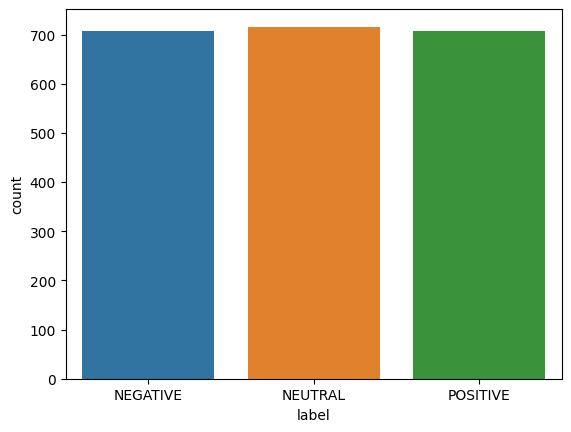

In [4]:
sns.countplot(x='label', data=df)



# df.isnull().sum().sum()



encode = ({'NEUTRAL': 0, 'POSITIVE': 1, 'NEGATIVE': 0} )

df_encoded = df.replace(encode)



X=df_encoded.drop(["label"]  ,axis=1)

y = df_encoded.loc[:,'label'].values

In [5]:
X_orig=df_encoded.drop(["label"]  ,axis=1)

y_orig = to_categorical(df_encoded.loc[:,'label'].values)

In [6]:
scaler = StandardScaler()

scaler.fit(X)

X = scaler.transform(X)

y = to_categorical(y)

# print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(X_train.shape)

X_train = np.reshape(X_train, (X_train.shape[0],1,X.shape[1]))

X_test = np.reshape(X_test, (X_test.shape[0],1,X.shape[1]))

print(f"X_train  shape: {X_train.shape}")

print(f"X_test  shape: {X_test.shape}")

print(y_train.shape)  # Should be (num_samples, num_classes)

print(y_test.shape)


(1705, 2548)
X_train  shape: (1705, 1, 2548)
X_test  shape: (427, 1, 2548)
(1705, 2)
(427, 2)


In [7]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import random

# Assuming ACO utility functions for hyperparameter selection

# Define ranges for hyperparameters
lstm_units_options = [32, 64, 128]
dropout_rate_options = [0.2, 0.3, 0.4]
learning_rate_options = [0.001, 0.005, 0.01]

# Define ACO parameters
num_ants = 10
num_generations = 5
alpha = 1.0  # pheromone importance
beta = 1.0   # heuristic importance
evaporation_rate = 0.5

# Initialize pheromone levels
pheromone_levels = {
    'lstm_units': np.ones(len(lstm_units_options)),
    'dropout_rate': np.ones(len(dropout_rate_options)),
    'learning_rate': np.ones(len(learning_rate_options))
}

# Define fitness function
def evaluate_model(lstm_units, dropout_rate, learning_rate):
    model = Sequential([
        LSTM(lstm_units, input_shape=(1, 2548), activation="relu", return_sequences=True),
        Dropout(dropout_rate),
        LSTM(lstm_units // 2, activation="relu", return_sequences=True),
        Dropout(dropout_rate),
        LSTM(lstm_units // 4, activation="relu"),
        Dropout(dropout_rate),
        Dense(2, activation='sigmoid')
    ])

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=0)
    
    # Evaluate the model
    score, acc = model.evaluate(X_test, y_test, verbose=0)
    return model, acc  # Return model and its accuracy

# ACO optimization loop
best_model = None
best_accuracy = 0.0
best_params = {}

for generation in range(num_generations):
    ant_solutions = []
    
    for ant in range(num_ants):
        # Select parameters based on pheromone probability
        lstm_units = random.choices(lstm_units_options, weights=pheromone_levels['lstm_units'])[0]
        dropout_rate = random.choices(dropout_rate_options, weights=pheromone_levels['dropout_rate'])[0]
        learning_rate = random.choices(learning_rate_options, weights=pheromone_levels['learning_rate'])[0]
        
        # Evaluate model with chosen parameters
        model, acc = evaluate_model(lstm_units, dropout_rate, learning_rate)
        
        ant_solutions.append((model, acc, {'lstm_units': lstm_units, 'dropout_rate': dropout_rate, 'learning_rate': learning_rate}))
        
        # Update best model if current model is better
        if acc > best_accuracy:
            best_model = model
            best_accuracy = acc
            best_params = {'lstm_units': lstm_units, 'dropout_rate': dropout_rate, 'learning_rate': learning_rate}
    
    # Update pheromone levels
    for param, options in [('lstm_units', lstm_units_options), ('dropout_rate', dropout_rate_options), ('learning_rate', learning_rate_options)]:
        for i, option in enumerate(options):
            # Calculate pheromone update based on ant solutions
            pheromone_increase = sum(acc for model, acc, params in ant_solutions if params[param] == option) / num_ants
            pheromone_levels[param][i] = (1 - evaporation_rate) * pheromone_levels[param][i] + pheromone_increase

# Save best model and print results
best_model.save("../../Models/EEG/best_lstm_aco_model.h5")
print(f"Best Accuracy after ACO: {best_accuracy}")
print(f"Best Parameters: {best_params}")

# Predict and calculate confusion matrix
pred = best_model.predict(X_test)
predicted_classes = np.argmax(pred, axis=1)
expected_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(expected_classes, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1730090021.906917      77 service.cc:145] XLA service 0x5934a88894c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730090021.906967      77 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1730090027.392657      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Best Accuracy after ACO: 0.9929742217063904
Best Parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001}
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Confusion Matrix:
 [[290   1]
 [  2 134]]
